## Druglikeness

In [1]:
from rdkit.Chem import AllChem as Chem
from rdkit.Chem import Descriptors
from rdkit.Chem import rdMolDescriptors as rdescriptors
from rdkit.Chem.Draw import IPythonConsole
import pandas as pd
import seaborn as sns
%matplotlib inline
import matplotlib.pyplot as plt

RDKit WARNING: [21:40:28] Enabling RDKit 2019.09.3 jupyter extensions


In [2]:
#Load data
df_can = pd.read_csv('cannabinoid.csv', delimiter=';')


In [3]:
#Load drugbank data
suppl = Chem.SDMolSupplier('../data/drugbank.sdf')
drugs = [m for m in suppl if m]

In [4]:
#Clean data
df1 = df_can.dropna(subset=['Smiles'])


In [5]:
#List of molecules instances
ligandm_database = []
for ligand in df1["Smiles"]:
		ligandm_database.append(Chem.MolFromSmiles(ligand))

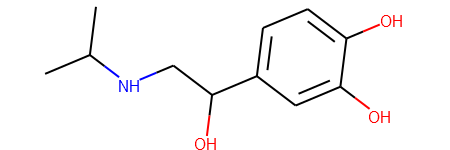

In [6]:
#Molecule
ligandm_database[12]

### Lipinski's rule of five

* no more than 5 hydrogen bond donors
* no more than 10 hydrogen bond acceptors
* molecular weight of less than 500 Da
* logP less than 5

In [7]:
#Lipinski's rule of five functions
def too_many_hbd(mol):
    return rdescriptors.CalcNumLipinskiHBD(mol) > 5

def too_many_hba(mol):
    return rdescriptors.CalcNumLipinskiHBA(mol) > 10

def too_heavy(mol):
    return rdescriptors.CalcExactMolWt(mol) > 500

def too_greasy(mol):
    return Descriptors.MolLogP(mol) > 5

In [8]:
# Let's check if molecule [12] pass our test

too_many_hbd(ligandm_database[12]), too_many_hba(ligandm_database[12]), \
too_heavy(ligandm_database[12]), too_greasy(ligandm_database[12])

(False, False, False, False)

So stucture [12] did pass the Lipinski filter

In [9]:
#Evaluation of whole dataset with the Lipinski filter
can_hbd = []
for x in ligandm_database:
		can_hbd.append(too_many_hbd(x))

can_hba = []
for x in ligandm_database:
		can_hba.append(too_many_hba(x))

can_heavy = []
for x in ligandm_database:
		can_heavy.append(too_heavy(x))


can_greasy = []
for x in ligandm_database:
		can_greasy.append(too_greasy(x))
        


In [10]:
df1_can = pd.DataFrame(data={'name':'cannabinoid',
                        'too_many_hbd': can_hbd,
                        'too_many_hba': can_hba,
                        'too_greasy': can_heavy,
                        'too_heavy': can_greasy})


In [11]:
# Function - Lipinski's violations
def ro5_violations(mol):
    return sum([too_many_hbd(mol), too_many_hba(mol), too_heavy(mol), too_greasy(mol)])

def violates_lipinski(mol):
    return ro5_violations(mol) > 1

In [12]:
# Number of molecules which do not pass the Lipinski's rules
can_ro5_violations = []
for x in ligandm_database:
    can_ro5_violations.append(ro5_violations(x)) 

can__violates_lipinski = []
for m in ligandm_database:
    can__violates_lipinski.append(violates_lipinski(m))


a = str(sum(can_ro5_violations))
b = str(round(sum(can_ro5_violations)/len(can_ro5_violations),2)*100)
c = str(sum(can__violates_lipinski))
d = str(round(sum(can__violates_lipinski)/len(can__violates_lipinski),2)*100)

print('Overall number of molecules which violate Lipinskis rules in our dataset is ' + a + ' which corresponds to ' + b + "% of our molecules. " + c + " molecules fail at least one of the Lipinski rule, which is about " + d + "%")
    

Overall number of molecules which violate Lipinskis rules in our dataset is 2034 which corresponds to 68.0% of our molecules. 446 molecules fail at least one of the Lipinski rule, which is about 15.0%


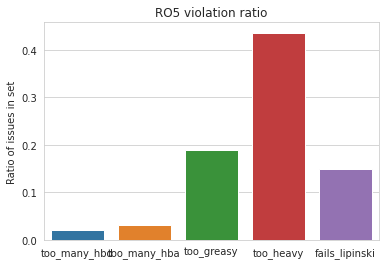

In [13]:
#Visualisation of Lipinski violation in our dataset
df1_can['fails_lipinski'] = can__violates_lipinski
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df1_can, ci=None)
    p.set_title("RO5 violation ratio")
    p.set_ylabel("Ratio of issues in set")

In [14]:
from rdkit.Chem import Crippen

#Ghose filter 
def bad_greasyness_ghose(mol):
    logp = Descriptors.MolLogP(mol)
    return logp > 5.6 or logp < -0.4

df1_can['odd_greasyness'] = [bad_greasyness_ghose(l) for l in ligandm_database]

def bad_refractivity_ghose(mol):
    ref = Crippen.MolMR(mol)
    return ref > 130 or ref < 40
df1_can['odd_refractivity'] = [bad_refractivity_ghose(l) for l in ligandm_database]

def bad_mw_ghose(mol):
    mw = rdescriptors.CalcExactMolWt(mol)
    return mw > 480 or mw < 180
df1_can['odd_mass'] = [bad_mw_ghose(l) for l in ligandm_database]

def bad_atomcount_ghose(mol):
    ac = mol.GetNumHeavyAtoms()
    return ac > 70 or ac < 20
df1_can['odd_atomcount'] = [bad_atomcount_ghose(l) for l in ligandm_database]

def violates_ghose(mol):
    return bad_greasyness_ghose(mol) or bad_refractivity_ghose(mol) or bad_mw_ghose(mol) or bad_atomcount_ghose(mol)
df1_can['fails_ghose'] = [violates_ghose(l) for l in ligandm_database]

def too_rotatable_veber(mol):
    return Chem.CalcNumRotatableBonds(mol) > 10
df1_can['too_rotatable'] = [too_rotatable_veber(l) for l in ligandm_database]

def too_large_psa_veber(mol):
    return rdescriptors.CalcTPSA(mol) > 140
df1_can['excessive_psa'] = [too_large_psa_veber(l) for l in ligandm_database]

def violates_veber(mol):
    return too_rotatable_veber(mol) or too_large_psa_veber(mol)
df1_can['fails_veber'] = [violates_veber(l) for l in ligandm_database]

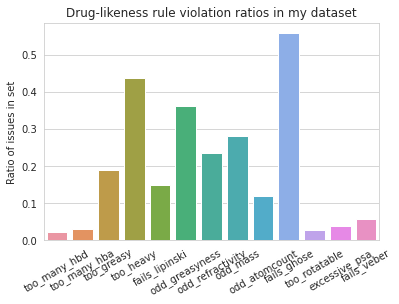

In [15]:
#Visualisation of drug-likeness rule violation ratios
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df1_can, ci=None)
    p.set_title("Drug-likeness rule violation ratios in my dataset")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=30) 

In [16]:
#Drugbank
df_drugbank = pd.DataFrame(
    data={'set':'DrugBank',
          'too_many_hbd': [too_many_hbd(l) for l in drugs],
          'too_many_hba': [too_many_hba(l) for l in drugs],
          'too_greasy': [too_greasy(l) for l in drugs],
          'too_heavy': [too_heavy(l) for l in drugs],
          'fails_lipinski': [violates_lipinski(l) for l in drugs],
          'odd_greasyness': [bad_greasyness_ghose(l) for l in drugs],
          'odd_refractivity': [bad_refractivity_ghose(l) for l in drugs],
          'odd_mass': [bad_mw_ghose(l) for l in drugs],
          'odd_atomcount': [bad_atomcount_ghose(l) for l in drugs],
          'fails_ghose': [violates_ghose(l) for l in drugs],
          'too_rotatable': [too_rotatable_veber(l) for l in drugs],
          'excessive_psa': [too_large_psa_veber(l) for l in drugs],
          'fails_veber': [violates_veber(l) for l in drugs]})
df_drugbank

,set,too_many_hbd,too_many_hba,too_greasy,too_heavy,fails_lipinski,odd_greasyness,odd_refractivity,odd_mass,odd_atomcount,fails_ghose,too_rotatable,excessive_psa,fails_veber
0,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
1,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
2,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
3,DrugBank,True,True,False,True,True,True,True,True,True,True,True,True,True
4,DrugBank,False,True,False,True,True,False,True,True,True,True,True,True,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7108,DrugBank,False,False,False,False,False,False,True,True,True,True,False,False,False
7109,DrugBank,False,False,False,False,False,True,False,False,False,True,False,True,True
7110,DrugBank,True,True,False,True,True,False,True,True,True,True,True,True,True
7111,DrugBank,False,False,False,False,False,False,False,False,False,False,True,False,True


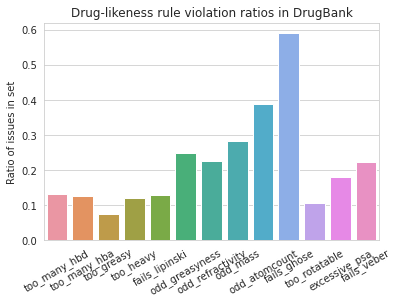

In [17]:
# Visualisation of drugbank's violation
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df_drugbank, ci=None)
    p.set_title("Drug-likeness rule violation ratios in DrugBank")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=30) 

In [18]:
#Lead-likeness filter
#LogP 3 or less, molecular weight below 300 Da, max 3 HBA, max 3 HBD, and no more than 3 rotatable bonds

def too_greasy_lead(mol):
    return Descriptors.MolLogP(mol) > 3

def too_heavy_lead(mol):
    return rdescriptors.CalcExactMolWt(mol) > 300

def too_many_hbd_lead(mol):
    return rdescriptors.CalcNumLipinskiHBD(mol) > 3

def too_many_hba_lead(mol):
    return rdescriptors.CalcNumLipinskiHBA(mol) > 3

def too_rotatable_lead(mol):
    return Chem.CalcNumRotatableBonds(mol) > 3

# Function - LeadLike violation
def ro5_violations(mol):
    return sum([too_many_hbd_lead(mol), too_many_hba_lead(mol), too_heavy_lead(mol), too_greasy_lead(mol), too_rotatable_lead(mol)])

def violates_leadlike(mol):
    return ro5_violations(mol) > 3


df_leadlike = pd.DataFrame(
    data={'set':'LeadLike',
          'too_greasy_lead': [too_greasy_lead(l) for l in ligandm_database],
          'too_heavy_lead': [too_heavy_lead(l) for l in ligandm_database],
          'too_many_hbd_lead': [too_many_hbd_lead(l) for l in ligandm_database],
          'too_many_hba_lead': [too_many_hba_lead(l) for l in ligandm_database],
          'too_rotatable_lead': [violates_lipinski(l) for l in ligandm_database],
           'fails_leadlike': [violates_leadlike(l) for l in ligandm_database],})




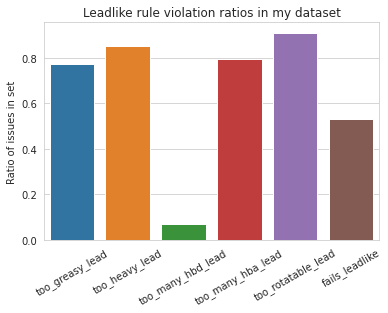

In [19]:
# Visualisation of LeadLike's violation
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df_leadlike, ci=None)
    p.set_title("Leadlike rule violation ratios in my dataset")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=30) 

In [20]:
# Leadlike violation my dataset
can_ro5_violations = []
for x in ligandm_database:
    can_ro5_violations.append(ro5_violations(x)) 

can__violates_lipinski = []
for m in ligandm_database:
    can__violates_lipinski.append(violates_leadlike(m))

c = str(sum(can__violates_lipinski))
d = str(round(sum(can__violates_lipinski)/len(can__violates_lipinski),2)*100)

print(  c + " molecules fails  the LeadLike test, which is about " + d + "%")



1595 molecules fails  the LeadLike test, which is about 53.0%


In [21]:
df_leadlike_drugbank = pd.DataFrame(
    data={'set':'LeadLike_Drugbank',
          'too_greasy_lead': [too_greasy_lead(l) for l in drugs],
          'too_heavy_lead': [too_heavy_lead(l) for l in drugs],
          'too_many_hbd_lead': [too_many_hbd_lead(l) for l in drugs],
          'too_many_hba_lead': [too_many_hba_lead(l) for l in drugs],
          'too_rotatable_lead': [violates_lipinski(l) for l in drugs],
           'fails_leadlike': [violates_leadlike(l) for l in drugs],})
df_leadlike_drugbank 

,set,too_greasy_lead,too_heavy_lead,too_many_hbd_lead,too_many_hba_lead,too_rotatable_lead,fails_leadlike
0,LeadLike_Drugbank,False,True,True,True,True,True
1,LeadLike_Drugbank,False,True,True,True,True,True
2,LeadLike_Drugbank,False,True,True,True,True,True
3,LeadLike_Drugbank,False,True,True,True,True,True
4,LeadLike_Drugbank,True,True,True,True,True,True
...,...,...,...,...,...,...,...
7108,LeadLike_Drugbank,False,False,False,False,False,False
7109,LeadLike_Drugbank,False,True,True,True,True,False
7110,LeadLike_Drugbank,False,True,True,True,True,True
7111,LeadLike_Drugbank,False,True,False,True,True,False


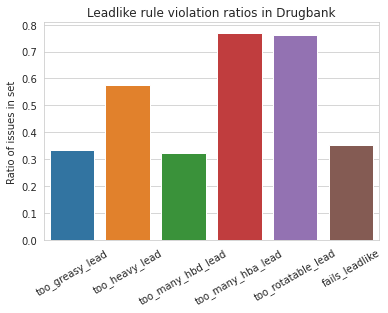

In [22]:
# Visualisation of LeadLike's violation
with sns.axes_style("whitegrid"):
    p = sns.barplot(data=df_leadlike_drugbank, ci=None)
    p.set_title("Leadlike rule violation ratios in Drugbank")
    p.set_ylabel("Ratio of issues in set")
    p.set_xticklabels(p.get_xticklabels(), rotation=30) 

In [23]:
# Leadlike violation
can_ro5_violations = []
for x in drugs:
    can_ro5_violations.append(ro5_violations(x)) 

can__violates_lipinski = []
for m in drugs:
    can__violates_lipinski.append(violates_leadlike(m))

c = str(sum(can__violates_lipinski))
d = str(round(sum(can__violates_lipinski)/len(can__violates_lipinski),2)*100)

print(  c + " molecules fails  the LeadLike test, which is about " + d + "%")

2503 molecules fails  the LeadLike test, which is about 35.0%


## Summary

* In my dataset 446 molecules fail at least one of the Lipinski rule, which is about 15.0%.
* The most molecules in my dataset violate the rule about the molecular weight which should be less than 500 DA and also the rule  logP which should be less than 5.
* According to Ghose filter, most of ligands in my dataset have too many heavy atoms and bad polarizability.
* In drugbank dataset about 25% molecules violate Lipinski rules.
* Most of ligands in drugbank have too heavy atoms and high logP and molecular weight. 
* In my dataset 1595 molecules fails  the LeadLike test, which is about 53.0%. Most molecules violate the rule about no more than 3 rotatable bonds. And the second most violated rule is about he molecular weight.
* In drugbank dataset 2503 molecules fails  the LeadLike test, which is about 35.0%. Most of molecules violate the rule about the number of hydrogen bond acceptors, which is in this case max 3 HBA. The second most violated rule is about no more than 3 rotatable bonds.

